In [1]:
import os
import sys
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from choice_learn.models.base_model import ChoiceModel
from choice_learn.data import ChoiceDataset

#======================================
# Set device
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print(f"Use GPU: {tf.config.list_physical_devices('GPU')[0]}")
else:
    device = '/CPU:0'
    print("Use CPU")

2025-12-29 07:55:26.543907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-29 07:55:26.543987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-29 07:55:26.545161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-29 07:55:26.551749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-29 07:55:27.183149: W tensorflow/compiler/tf2

Use GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-12-29 07:55:29.736526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:29.824209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:29.824279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
project_root = os.path.abspath(os.getcwd())
sys.path.insert(0, project_root)

# Make sure you are in the package's main directory
print(project_root)

/root/Q3/DeepHalo-tf/Final/DeepHalo


In [4]:
from DeepHalo import DeepHaloChoiceModel

Initializing DeepHaloChoiceModel package v1.0.0


# Load Data from ChoiceDataset

In [5]:
from choice_learn.datasets import load_swissmetro
from choice_learn.datasets import load_modecanada

dataset_name = 'swiss'

def choose_dataset(dataset_name):
    if dataset_name == 'swiss':

        # Load SwissMetro (transportation) data
        swiss_df = load_swissmetro(as_frame=True)
        
        kept_columns = [
            "PURPOSE", "AGE",
            "CAR_AV", "TRAIN_AV", "SM_AV",
            "CAR_TT", "TRAIN_TT", "SM_TT",
            "CAR_CO", "TRAIN_CO", "SM_CO",
            "CHOICE",
        ]
        swiss_df = swiss_df[kept_columns]

        # Build ChoiceDataset in wide format
        dataset = ChoiceDataset.from_single_wide_df(
            df=swiss_df,
            items_id=["TRAIN", "SM", "CAR"],   # names used in *_AV, *_TT, *_CO columns
            choices_column="CHOICE",
            choice_format="items_index",       # CHOICE is 0/1/2 index of TRAIN/SM/CAR
            shared_features_columns=None,
            items_features_suffixes=["CO", "TT"],    # features: *_CO, *_TT
            available_items_suffix="AV",
            delimiter="_",
        )

    elif dataset_name == 'canada':

        # Load ModeCanada (transportation) data
        canada_transport_df = load_modecanada(as_frame=True)
    
        dataset = ChoiceDataset.from_single_long_df(
        df=canada_transport_df,
        choices_column="choice",
        items_id_column="alt",
        choices_id_column="case",
        shared_features_columns=None,
        items_features_columns=["cost", "freq", "ovt", "ivt"],
        choice_format="one_zero")

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}") 

    return dataset


dataset = choose_dataset(dataset_name)
print(dataset.summary())


%=====================================================================%
%%% Summary of the dataset:
%=====================================================================%
Number of items: 3
Number of choices: 10719
%=====================================================================%
 No Shared Features by Choice registered


 Items Features by Choice:
2 items features 
 with names: (['CO', 'TT'],)
%=====================================================================%



# Train

In [6]:
def build_model(H, depth, embed, featureless=True, feature2D=False, epochs=20, batch_size=64, loss_name='nll', **kwargs):
    # build a DeepHalo choice model with the given specifications
    
    DeepHalo_model = DeepHaloChoiceModel(
    H=H,
    depth=depth,
    embed=embed,
    featureless=featureless,
    feature2D=feature2D,
    epochs=epochs,
    batch_size=batch_size,
    loss_name=loss_name,
    )
    
    return DeepHalo_model


In [7]:
def count_net_params(dataset, budget, embed, featureless=True, feature2D=False, H_min=2, H_max=100, depth_min=3, depth_max=8, **kwargs):
    # function to specify the (depth, H) configuration for the network that matches the given budget

    avail = dataset.available_items_by_choice.astype(np.float32)[:2]
    X_items = dataset.items_features_by_choice[0].astype(np.float32)[:2]
    


    candidates = []

    H = H_max + 1
    for depth in range(depth_min, depth_max):
        min_diff = 1e9
        while H>= H_min:            
            DeepHalo_model = build_model(H, depth, embed, featureless, feature2D)
            _ = DeepHalo_model.deep_halo_core(X_items, avail, training=False)
            p = DeepHalo_model.deep_halo_core.count_params()
            diff = abs(p-budget)
            if diff <= min_diff:
                min_diff = diff
                p_saved = p
                H_saved = H
            else: 
                p = p_saved
                H = H_saved
                candidates.append((depth, H, p))
                break
            
            H -= 1
        
    return candidates
    

In [8]:
def get_configs(dataset, budgets, embed, featureless=True, feature2D=False, H_min=2, H_inf=10000, depth_min=3, depth_max=8, **kwargs):
    # function to return a configs dictionary for all given budgets 

    J = dataset.base_num_items
    configs_dict = {} 
    for budget in Budgets:
        key = f"{int(budget/1000)}k" 
        if featureless:
            H_max = int(H_inf/J)
        else:
            H_max = int(H_inf/(J*embed))
        configs = count_net_params(dataset, budget, embed, featureless, feature2D, H_min, H_max, depth_min, depth_max)
        configs_dict[key] = [config[:2] for config in configs]

    return configs_dict

In [9]:
# avail = dataset.available_items_by_choice.astype(np.float32)[:2]
# X_items = dataset.items_features_by_choice[0].astype(np.float32)[:2]

# budget = 200e3
# depth = 5
# H = 7
# embed = 32
# featureless = False
# feature2D = False
        
# DeepHalo_model = build_model(H, depth, embed, featureless, feature2D)
# _ = DeepHalo_model.deep_halo_core(X_items, avail, training=False)
# abs(DeepHalo_model.deep_halo_core.count_params() - budget)


In [10]:
Budgets = [200000, 500000]
embed = 32
featureless = False
feature2D = False
if featureless:
    embed = J
configs_dict = get_configs(dataset, Budgets, embed, featureless, feature2D, H_min=2, H_inf=5000, depth_min=1, depth_max=6)
configs_dict


2025-12-29 07:55:39.695637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:39.695755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:39.695810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:41.004980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 07:55:41.005081: I external/local_xla/xla/stream_executor

{'200k': [(1, 13), (2, 9), (3, 7), (4, 6), (5, 6)],
 '500k': [(1, 21), (2, 15), (3, 12), (4, 10), (5, 9)]}

In [11]:
def train_deephalo_real(dataset, dataset_name, budget, H, depth, embed, featureless, 
                             feature2D, epochs, batch_size, loss_name, 
                             save_path, **kwargs ):

    
    # function to train DeepHalo method for different experiments for different budget, etc.
    
    avail = dataset.available_items_by_choice.astype(np.float32)
    X_items = dataset.items_features_by_choice[0].astype(np.float32)      # [N, J, D0]  
       

    DeepHalo_model = build_model(H, depth, embed, featureless, feature2D, epochs, batch_size, loss_name)
    _ = DeepHalo_model.deep_halo_core(X_items[:2], avail[:2], training=False)

    history = DeepHalo_model.fit(dataset)

    
    # Save weights
    DeepHalo_model.deep_halo_core.save_weights(
        os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-{dataset_name}.weights.h5')
    )
    
    # Save training history as numpy file
    np.save(
        os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-{dataset_name}-hist.npy'),
        history
    )

In [12]:
file_load_path = os.path.join(project_root, 'Data')

# Save path
file_save_path = os.path.join(project_root, 'Experiments', 'Real')
os.makedirs(file_save_path, exist_ok=True)



epochs = 500
batch_size = 64  # Reduced batch size to help with memory
lr = 0.001


Budgets = [200000, 500000]

featureless = False
feature2D = False
loss_name = 'nll'


J = dataset.base_num_items

configs_dict_list = []
embeds = [ 32]

for embed in embeds:
    print(f'=== Testing embed: {embed} ===')

    if featureless:
        embed = J

    configs_dict = get_configs(dataset, Budgets, embed, featureless, feature2D, H_min=2, H_inf=5000, depth_min=1, depth_max=6)
    configs_dict_list.append(configs_dict)
    for budget, depth_H in configs_dict.items():
        
        print(f'=== Testing Budget Group: {budget} ===')
        for depth, H in depth_H:
            print(f'Depth: {depth}, H: {H}')
            train_deephalo_real(dataset, dataset_name, budget, H, depth, embed, featureless, feature2D, epochs, batch_size, loss_name, file_save_path )



=== Testing embed: 32 ===
=== Testing Budget Group: 200k ===
Depth: 1, H: 13


  0%|                                                                                           | 0/500 [00:00<?, ?it/s]2025-12-26 13:05:15.738636: I external/local_xla/xla/service/service.cc:168] XLA service 0x778ba80e3df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 13:05:15.738833: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-26 13:05:15.755374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-26 13:05:15.795046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1766714715.861521    3291 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 499 Train Loss 0.6188: 100%|███████████████████████████████

Depth: 2, H: 9


Epoch 499 Train Loss 0.1836: 100%|████████████████████████████████████████████████████| 500/500 [15:02<00:00,  1.80s/it]


Depth: 3, H: 7


Epoch 499 Train Loss 0.1668: 100%|████████████████████████████████████████████████████| 500/500 [16:50<00:00,  2.02s/it]


Depth: 4, H: 6


Epoch 499 Train Loss 0.1803: 100%|████████████████████████████████████████████████████| 500/500 [19:24<00:00,  2.33s/it]


Depth: 5, H: 6


Epoch 499 Train Loss 0.1596: 100%|████████████████████████████████████████████████████| 500/500 [22:48<00:00,  2.74s/it]


=== Testing Budget Group: 500k ===
Depth: 1, H: 21


Epoch 499 Train Loss 0.6072: 100%|████████████████████████████████████████████████████| 500/500 [11:35<00:00,  1.39s/it]


Depth: 2, H: 15


Epoch 499 Train Loss 0.1574: 100%|████████████████████████████████████████████████████| 500/500 [14:47<00:00,  1.77s/it]


Depth: 3, H: 12


Epoch 499 Train Loss 0.1579: 100%|████████████████████████████████████████████████████| 500/500 [18:34<00:00,  2.23s/it]


Depth: 4, H: 10


Epoch 499 Train Loss 0.1506: 100%|████████████████████████████████████████████████████| 500/500 [19:13<00:00,  2.31s/it]


Depth: 5, H: 9


Epoch 499 Train Loss 0.1496: 100%|████████████████████████████████████████████████████| 500/500 [21:04<00:00,  2.53s/it]


<Figure size 1000x600 with 0 Axes>

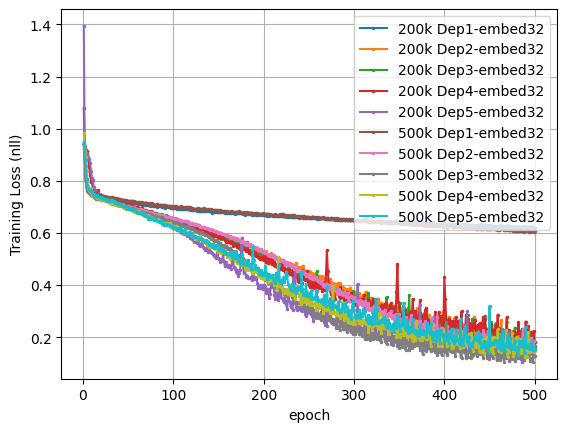

In [13]:
# Define the file path
file_save_path = os.path.join(project_root, 'Experiments', 'Real')

# epochs = 500
# batch_size = 64  # Reduced batch size to help with memory
# lr = 0.001


# Budgets = [200000, 500000]

# featureless = False
# feature2D = False
# loss_name = 'nll'

# J = dataset.base_num_items


# embeds = [ 32]



loss_dict = {}
cnt = -1

for embed in embeds:
    cnt += 1
    if featureless:
        embed = J

    configs_dict = configs_dict_list[cnt]
    
    for budget, depth_H in configs_dict.items():
        for depth, H in depth_H:
            
            filename = os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-{dataset_name}-hist.npy')
    
            # Load the model info
            history = np.load(filename, allow_pickle=True).item()
    
            key = f"{budget} Dep{depth}-embed{embed}"
            train_loss_tensors = history['train_loss']
            train_losses = [float(l) for l in train_loss_tensors]
            loss_dict[key] = train_losses

df = pd.DataFrame(loss_dict)
df.index = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
ax = df.plot(kind='line', linewidth=1.5, marker=".", markersize=3)
ax.set_xlabel("epoch")
# ax.set_yscale('log')
ax.set_ylabel(f"Training Loss ({loss_name})")
plt.grid(True)
plt.savefig(os.path.join(file_save_path, f'plot-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-{dataset_name}.pdf'), format='pdf', bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

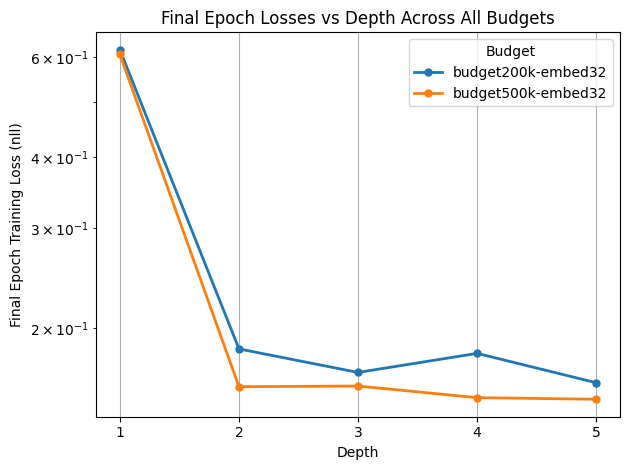

In [14]:
# Extract all unique depths across all experiments
all_depths = set()
final_losses = {}

cnt = -1
for embed in embeds:
    cnt += 1
    if featureless:
        embed = J

    configs_dict = configs_dict_list[cnt]
    
    for budget, depth_H in configs_dict.items():
        for depth, H in depth_H:
            key = f"{budget} Dep{depth}-embed{embed}"
            if key in loss_dict:  # Only if data exists
                all_depths.add(depth)
                if embed not in final_losses:
                    final_losses[embed] = {}
                if budget not in final_losses[embed]:
                    final_losses[embed][budget] = {}
                final_losses[embed][budget][depth] = loss_dict[key][-1]



# Create sorted depths and DataFrame
depths = sorted(all_depths)[::-1]
df_data = {}
for embed in final_losses:
    for budget in final_losses[embed]:
        df_data[f"budget{budget}-embed{embed}"] = [final_losses[embed][budget].get(depth) for depth in depths]

df = pd.DataFrame(df_data, index=depths)

# Line plot for all budgets
plt.figure(figsize=(10, 6))
ax = df.plot(kind='line', marker='o', linewidth=2, markersize=5)
plt.xlabel('Depth')
plt.ylabel(f'Final Epoch Training Loss ({loss_name})')
plt.title('Final Epoch Losses vs Depth Across All Budgets')
plt.legend(title='Budget', loc='upper right')

plt.xticks(depths)
plt.grid(True)

plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(file_save_path, f'plot-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-{dataset_name}_final.pdf'), format='pdf', bbox_inches='tight')
plt.show()

